In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import sqlite3
from sqlalchemy import create_engine # database connection
import csv
import os
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier


from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

## Reading data and basic stats 

In [74]:
df = pd.read_csv("train.csv")

print("Number of data points:",df.shape[0])

Number of data points: 404290


In [75]:
df.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate'], dtype='object')

In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404289 non-null object
question2       404288 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [77]:
df.describe()

,id,qid1,qid2,is_duplicate
count,404290.000000,404290.000000,404290.000000,404290.000000
mean,202144.500000,217243.942418,220955.655337,0.369198
std,116708.614503,157751.700002,159903.182629,0.482588
min,0.000000,1.000000,2.000000,0.000000
25%,101072.250000,74437.500000,74727.000000,0.000000
50%,202144.500000,192182.000000,197052.000000,0.000000
75%,303216.750000,346573.500000,354692.500000,1.000000
max,404289.000000,537932.000000,537933.000000,1.000000


## Data Cleaning


In [78]:
# encode questions to unicode
# https://stackoverflow.com/a/6812069
# ----------------- python 2 ---------------------
# df['question1'] = df['question1'].apply(lambda x: unicode(str(x),"utf-8"))
# df['question2'] = df['question2'].apply(lambda x: unicode(str(x),"utf-8"))
# ----------------- python 3 ---------------------
df['question1'] = df['question1'].apply(lambda x: str(x))
df['question2'] = df['question2'].apply(lambda x: str(x))

In [79]:
#Checking whether there are any rows with null values
nan_rows = df[df.isnull().any(1)]
print (nan_rows)


Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


In [80]:
# Filling the null values with ' '
#df = df.fillna('')
#https://stackoverflow.com/questions/44548721/remove-row-with-null-value-from-pandas-data-frame
df = df.dropna(how='any',axis=0) 
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


## Cleaning Empty rows from dataset.

In [81]:
df.iloc[13016]

id                                           13016
qid1                                         25026
qid2                                         25027
question1                                        ?
question2       Why should one not work at Google?
is_duplicate                                     0
Name: 13016, dtype: object

In [82]:
df.iloc[20072]

id                                20072
qid1                              37898
qid2                              37899
question1       How could I solve this?
question2                        …………..
is_duplicate                          0
Name: 20072, dtype: object

In [83]:
df.iloc[47056]

id                                                          47056
qid1                                                        84067
qid2                                                        84068
question1       Is there anywhere in the world offering pain m...
question2                                                       ?
is_duplicate                                                    0
Name: 47056, dtype: object

In [84]:
df.iloc[20794]

id                                                          20794
qid1                                                        39204
qid2                                                        39205
question1                                                       ?
question2       What is the Gmail tech support help phone number?
is_duplicate                                                    0
Name: 20794, dtype: object

In [85]:
df.iloc[3306]

id                                                           3306
qid1                                                         6553
qid2                                                         6554
question1                                                       .
question2       Why is Cornell's endowment the lowest in the I...
is_duplicate                                                    0
Name: 3306, dtype: object

In [86]:
print(df.shape)
df = df.drop(df.index[[3306,20794,47056,20072,13016]])
print(df.shape)

(404290, 6)
(404285, 6)


## Splitting Data into Train, Test and cross validation

In [87]:
#https://www.geeksforgeeks.org/how-to-randomly-select-rows-from-pandas-dataframe/
#quora_data= df.sample(frac =.15)
quora_data=df[0:50000]
quora_data.shape

(50000, 6)

In [92]:
quora_data.groupby('is_duplicate').count()

,id,qid1,qid2,question1,question2
is_duplicate,,,,,
0,31347,31347,31347,31347,31347
1,18653,18653,18653,18653,18653


In [16]:
is_duplicate=quora_data.pop('is_duplicate')

In [17]:
#https://stackoverflow.com/questions/36997619/sklearn-stratified-sampling-based-on-a-column
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split( quora_data, is_duplicate, test_size=0.30, random_state=42, stratify=is_duplicate)

In [18]:
#https://datascience.stackexchange.com/questions/15135/train-test-validation-set-splitting-in-sklearn
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.30, random_state=42, stratify=y_train)

In [19]:
print("Train shape")
print(x_train.shape)
print(y_train.shape)
print("-"*75)
print("Test shape")
print(x_test.shape)
print(y_test.shape)
print("-"*75)
print("Cross Validation shape")
print(x_val.shape)
print(y_val.shape)

Train shape
(24500, 5)
(24500,)
---------------------------------------------------------------------------
Test shape
(15000, 5)
(15000,)
---------------------------------------------------------------------------
Cross Validation shape
(10500, 5)
(10500,)


<h2>Basic Feature Extraction (before cleaning) </h2>

Let us now construct a few features like:
 - ____freq_qid1____ = Frequency of qid1's
 - ____freq_qid2____ = Frequency of qid2's 
 - ____q1len____ = Length of q1
 - ____q2len____ = Length of q2
 - ____q1_n_words____ = Number of words in Question 1
 - ____q2_n_words____ = Number of words in Question 2
 - ____word_Common____ = (Number of common unique words in Question 1 and Question 2)
 - ____word_Total____ =(Total num of words in Question 1 + Total num of words in Question 2)
 - ____word_share____ = (word_common)/(word_Total)
 - ____freq_q1+freq_q2____ = sum total of frequency of qid1 and qid2 
 - ____freq_q1-freq_q2____ = absolute difference of frequency of qid1 and qid2 

In [20]:
def normalized_word_Common(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)
    

def normalized_word_Total(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * (len(w1) + len(w2))
    

def normalized_word_share(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)/(len(w1) + len(w2))

In [21]:
def feature_extraction(df):
    df['freq_qid1'] = df.groupby('qid1')['qid1'].transform('count') 
    df['freq_qid2'] = df.groupby('qid2')['qid2'].transform('count')
    df['q1len'] = df['question1'].str.len() 
    df['q2len'] = df['question2'].str.len()
    df['q1_n_words'] = df['question1'].apply(lambda row: len(row.split(" ")))
    df['q2_n_words'] = df['question2'].apply(lambda row: len(row.split(" ")))
    df['word_Common'] = df.apply(normalized_word_Common, axis=1)
    df['word_Total'] = df.apply(normalized_word_Total, axis=1)
    df['word_share'] = df.apply(normalized_word_share, axis=1)
    df['freq_q1+q2'] = df['freq_qid1']+df['freq_qid2']
    df['freq_q1-q2'] = abs(df['freq_qid1']-df['freq_qid2'])
    return df

In [22]:
x_train=feature_extraction(x_train)
x_val=feature_extraction(x_val)
x_test=feature_extraction(x_test)

In [23]:
print("New Shape")
print("-*"*50)
print("Train shape")
print(x_train.shape)
print(y_train.shape)
print("-"*75)
print("Test shape")
print(x_test.shape)
print(y_test.shape)
print("-"*75)
print("Cross Validation shape")
print(x_val.shape)
print(y_val.shape)

New Shape
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
Train shape
(24500, 16)
(24500,)
---------------------------------------------------------------------------
Test shape
(15000, 16)
(15000,)
---------------------------------------------------------------------------
Cross Validation shape
(10500, 16)
(10500,)


## Preprocessing of Text

- Preprocessing:
    - Removing html tags 
    - Removing Punctuations
    - Performing stemming
    - Removing Stopwords
    - Expanding contractions etc.

In [24]:
# To get the results in 4 decemal points
SAFE_DIV = 0.0001 

STOP_WORDS = stopwords.words("english")


def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
               
    
    return x

<h2> 3.5 Advanced Feature Extraction (NLP and Fuzzy Features) </h2>

Definition:
- __Token__: You get a token by splitting sentence a space
- __Stop_Word__ : stop words as per NLTK.
- __Word__ : A token that is not a stop_word


Features:
- __cwc_min__ :  Ratio of common_word_count to min lenghth of word count of Q1 and Q2 <br>cwc_min = common_word_count / (min(len(q1_words), len(q2_words))
<br>
<br>
- __cwc_max__ :  Ratio of common_word_count to max lenghth of word count of Q1 and Q2 <br>cwc_max = common_word_count / (max(len(q1_words), len(q2_words))
<br>
<br>
- __csc_min__ :  Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2 <br> csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))
<br>
<br>
- __csc_max__ :  Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2<br>csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))
<br>
<br>
- __ctc_min__ :  Ratio of common_token_count to min lenghth of token count of Q1 and Q2<br>ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))
<br>
<br>

- __ctc_max__ :  Ratio of common_token_count to max lenghth of token count of Q1 and Q2<br>ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))
<br>
<br>
        
- __last_word_eq__ :  Check if First word of both questions is equal or not<br>last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])
<br>
<br>

- __first_word_eq__ :  Check if First word of both questions is equal or not<br>first_word_eq = int(q1_tokens[0] == q2_tokens[0])
<br>
<br>
        
- __abs_len_diff__ :  Abs. length difference<br>abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))
<br>
<br>

- __mean_len__ :  Average Token Length of both Questions<br>mean_len = (len(q1_tokens) + len(q2_tokens))/2
<br>
<br>


- __fuzz_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>

- __fuzz_partial_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_sort_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_set_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>





- __longest_substr_ratio__ :  Ratio of length longest common substring to min lenghth of token count of Q1 and Q2<br>longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))


In [25]:
def get_token_features(q1, q2):
    token_features = [0.0]*10
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features

# get the Longest Common sub string

def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

def extract_features(df):
    # preprocessing each question
    df["question1"] = df["question1"].fillna("").apply(preprocess)
    df["question2"] = df["question2"].fillna("").apply(preprocess)

    print("token features...")
    
    # Merging Features with dataset
    
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
   
    #Computing Fuzzy Features and Merging with Dataset
    
    # do read this blog: http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
    # https://stackoverflow.com/questions/31806695/when-to-use-which-fuzz-function-to-compare-2-strings
    # https://github.com/seatgeek/fuzzywuzzy
    print("fuzzy features..")

    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    return df

In [26]:
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz
import distance
from nltk.corpus import stopwords

In [27]:
print("Extracting features for train:")
x_train=extract_features(x_train)
print("Extracting features for cross validation:")
x_val=extract_features(x_val)
print("Extracting features for test:")
x_test=extract_features(x_test)

Extracting features for train:
token features...
fuzzy features..
Extracting features for cross validation:
token features...
fuzzy features..
Extracting features for test:
token features...
fuzzy features..


In [28]:
print("New Shape")
print("-*"*50)
print("Train shape")
print(x_train.shape)
print(y_train.shape)
print("-"*75)
print("Test shape")
print(x_test.shape)
print(y_test.shape)
print("-"*75)
print("Cross Validation shape")
print(x_val.shape)
print(y_val.shape)

New Shape
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
Train shape
(24500, 31)
(24500,)
---------------------------------------------------------------------------
Test shape
(15000, 31)
(15000,)
---------------------------------------------------------------------------
Cross Validation shape
(10500, 31)
(10500,)


In [29]:
x_test[x_test.question1=='']
#x_train.drop([13016,20072])

,id,qid1,qid2,question1,question2,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio


In [30]:
x_train[x_train.question2=='']


,id,qid1,qid2,question1,question2,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio


<h2> Featurizing text data with tfidf </h2>

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(lowercase=False)
# merge texts
questions_train = list(x_train['question1'])

q1_tfidf_train = vectorizer.fit_transform(questions_train)
print("Shape of Train matrix after one hot encodig for question 1 ",q1_tfidf_train.shape)
q1_train_feature_names=vectorizer.get_feature_names()

# dict key:word and value:tf-idf score
word2tfidf_train_q1 = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))

Shape of Train matrix after one hot encodig for question 1  (24500, 18796)


In [32]:
# merge texts
questions_val = list(x_val['question1']) 

q1_tfidf_val = vectorizer.transform(questions_val)
print("Shape of CV matrix after one hot encodig for question 1",q1_tfidf_val.shape)
q1_val_feature_names=vectorizer.get_feature_names()

# dict key:word and value:tf-idf score
word2tfidf_val_q1 = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))

Shape of CV matrix after one hot encodig for question 1 (10500, 18796)


In [33]:
# merge texts
questions_test = list(x_test['question1'])

q1_tfidf_test = vectorizer.transform(questions_test)
print("Shape of Test matrix after one hot encodig for question 1",q1_tfidf_test.shape)
q1_test_feature_names=vectorizer.get_feature_names()

# dict key:word and value:tf-idf score
word2tfidf_test_q1 = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))

Shape of Test matrix after one hot encodig for question 1 (15000, 18796)


In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(lowercase=False)
# merge texts
questions_train = list(x_train['question2'])

q2_tfidf_train = vectorizer.fit_transform(questions_train)
print("Shape of Train matrix after one hot encodig for question 2 ",q2_tfidf_train.shape)
q2_train_feature_names=vectorizer.get_feature_names()

# dict key:word and value:tf-idf score
word2tfidf_train_q2 = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))

Shape of Train matrix after one hot encodig for question 2  (24500, 17667)


In [35]:
# merge texts
questions_val =  list(x_val['question2'])

q2_tfidf_val = vectorizer.transform(questions_val)
print("Shape of CV matrix after one hot encodig for question 2",q2_tfidf_val.shape)
q2_val_feature_names=vectorizer.get_feature_names()

# dict key:word and value:tf-idf score
word2tfidf_val_q2 = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))

Shape of CV matrix after one hot encodig for question 2 (10500, 17667)


In [36]:
# merge texts
questions_test = list(x_test['question2'])

q2_tfidf_test = vectorizer.transform(questions_test)
print("Shape of  Test matrix after one hot encodig for question 2",q2_tfidf_test.shape)
q2_test_feature_names=vectorizer.get_feature_names()

# dict key:word and value:tf-idf score
word2tfidf_test_q2 = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))

Shape of  Test matrix after one hot encodig for question 2 (15000, 17667)


<h2> Featurizing text data with tfidf w2v </h2>

In [37]:
tfidf_w2v_train=pd.DataFrame()
tfidf_w2v_test=pd.DataFrame()
tfidf_w2v_val=pd.DataFrame()

In [38]:
import spacy
from tqdm import tqdm

In [39]:
# en_vectors_web_lg, which includes over 1 million unique vectors.
nlp = spacy.load('en_core_web_sm')

vecs1 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in list(x_train['question1']):
    doc1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    #mean_vec1=np.zeros(96)
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf_train_q1[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
tfidf_w2v_train['q1_feats_m'] = list(vecs1)

In [40]:
tfidf_w2v_train.head(5)

,q1_feats_m
0,"[-12.465866088867188, -47.608731269836426, -95..."
1,"[38.74498963356018, -70.20228959619999, -72.04..."
2,"[76.70058345794678, -116.75025498867035, -126...."
3,"[74.64223074913025, -41.05312171578407, 58.514..."
4,"[47.953317642211914, -33.4381677955389, -32.69..."


In [41]:
vecs1 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in list(x_train['question2']):
    doc1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    #mean_vec1=np.zeros(96)
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf_train_q2[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
tfidf_w2v_train['q2_feats_m'] = list(vecs1)

In [42]:
vecs1 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in list(x_val['question1']):
    doc1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    #mean_vec1=np.zeros(96)
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf_val_q1[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
tfidf_w2v_val['q1_feats_m'] = list(vecs1)

In [43]:
vecs1 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in list(x_val['question2']):
    doc1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    #mean_vec1=np.zeros(96)
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf_val_q2[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
tfidf_w2v_val['q2_feats_m'] = list(vecs1)

In [44]:
vecs1 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in list(x_test['question1']):
    doc1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    #mean_vec1=np.zeros(96)
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf_test_q1[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
tfidf_w2v_test['q1_feats_m'] = list(vecs1)

In [45]:
vecs1 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in list(x_test['question2']):
    doc1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    #mean_vec1=np.zeros(96)
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf_test_q2[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
tfidf_w2v_test['q2_feats_m'] = list(vecs1)

In [46]:
x_train.head(2)

,id,qid1,qid2,question1,question2,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
16615,16615,31664,31665,why is indonesia not an islamic nation,why is indonesia muslim,1,1,39,24,7,...,0.428565,0,1,3,5.5,82,66,66,75,0.680
10518,10518,20367,20368,what is the best definition of transdisciplin...,what is the best definition of science,1,1,53,39,7,...,0.857131,0,1,0,7.0,88,68,79,85,0.775


In [47]:
x_val.head(2)

,id,qid1,qid2,question1,question2,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
37002,37002,2246,23833,how can we improve the education system for hi...,what some things you would like to fix in high...,2,1,68,71,12,...,0.230767,0,0,1,12.5,54,51,41,44,0.188406
40950,40950,74020,74021,has anyone actually tried putting a garlic bas...,has anyone actually tried putting garlic based...,1,1,82,68,14,...,0.733328,1,1,4,13.0,100,91,91,79,0.492754


In [48]:
x_test.head(2)

,id,qid1,qid2,question1,question2,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
7259,7259,14186,14187,what is the reason why tadpoles blow bubbles ...,can we produce air bubbles remaining in water,1,1,106,46,21,...,0.045454,0,0,14,15.0,40,35,28,43,0.191489
20777,20777,39175,39176,what does donald trump think of india,donald trump what is donald trump own take on...,1,1,38,75,7,...,0.285712,0,0,7,10.5,77,56,53,79,0.384615


## Combining TFIDF Text Data

In [49]:
df_train = x_train.drop(['id','qid1','qid2','question1','question2'],axis=1)

In [50]:
df_val = x_val.drop(['id','qid1','qid2','question1','question2'],axis=1)

In [51]:
df_test = x_test.drop(['id','qid1','qid2','question1','question2'],axis=1)

In [52]:
print(df_train.shape)
print(df_val.shape)
print(df_test.shape)

(24500, 26)
(10500, 26)
(15000, 26)


In [53]:
final_train=hstack((df_train,q1_tfidf_train,q2_tfidf_train))
final_val=hstack((df_val,q1_tfidf_val,q2_tfidf_val))
final_test=hstack((df_test,q1_tfidf_test,q2_tfidf_test))

In [54]:
print(final_train.shape)
print(final_val.shape)
print(final_test.shape)

(24500, 36489)
(10500, 36489)
(15000, 36489)


In [55]:
print(tfidf_w2v_train.shape)
print(tfidf_w2v_val.shape)
print(tfidf_w2v_test.shape)

(24500, 2)
(10500, 2)
(15000, 2)


## Combining TFIDF W2V Text Data

In [56]:
final_train_tfidf_w2v=hstack((df_train,tfidf_w2v_train.q1_feats_m.values.tolist(),tfidf_w2v_train.q2_feats_m.values.tolist()))
final_val_tfidf_w2v=hstack((df_val,tfidf_w2v_val.q1_feats_m.values.tolist(),tfidf_w2v_val.q2_feats_m.values.tolist()))
final_test_tfidf_w2v=hstack((df_test,tfidf_w2v_test.q1_feats_m.values.tolist(),tfidf_w2v_test.q2_feats_m.values.tolist()))

In [57]:
print(final_train_tfidf_w2v.shape)
print(final_val_tfidf_w2v.shape)
print(final_test_tfidf_w2v.shape)

(24500, 218)
(10500, 218)
(15000, 218)


<h1>4. Machine Learning Models </h1>

In [58]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in cross validation data", "-"*10)
val_distr = Counter(y_val)
val_len = len(y_val)
print("Class 0: ",int(val_distr[1])/val_len, "Class 1: ",int(val_distr[1])/val_len)
print("-"*10, "Distribution of output variable in test data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[1])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.626938775510204 Class 1:  0.3730612244897959
---------- Distribution of output variable in cross validation data ----------
Class 0:  0.3730476190476191 Class 1:  0.3730476190476191
---------- Distribution of output variable in test data ----------
Class 0:  0.37306666666666666 Class 1:  0.37306666666666666


In [59]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

<h2> 4.4 Building a random model (Finding worst-case log-loss) </h2>

Log loss on Test Data using Random Model 0.8941303988297128


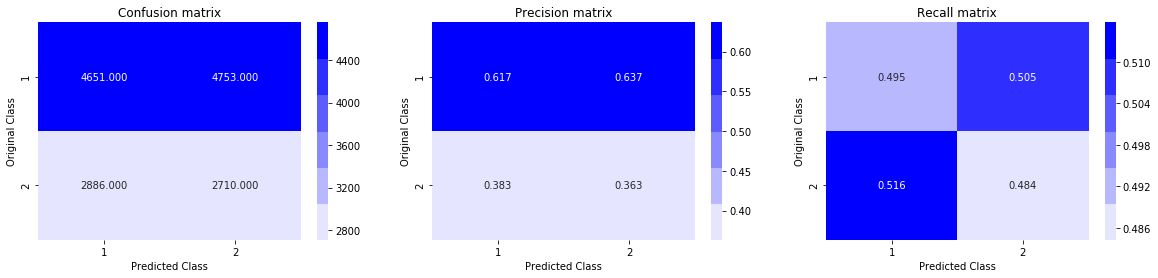

In [60]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
# we create a output array that has exactly same size as the CV data
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

<h2> 4.4 Logistic Regression with hyperparameter tuning </h2>

In [61]:
x_train.head(1)

,id,qid1,qid2,question1,question2,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
16615,16615,31664,31665,why is indonesia not an islamic nation,why is indonesia muslim,1,1,39,24,7,...,0.428565,0,1,3,5.5,82,66,66,75,0.68


For values of alpha =  1e-05 The log loss is: 0.501113987723453
For values of alpha =  0.0001 The log loss is: 0.5385031175521265
For values of alpha =  0.001 The log loss is: 0.5052686318402817
For values of alpha =  0.01 The log loss is: 0.5285310858467781
For values of alpha =  0.1 The log loss is: 0.5535493638042847
For values of alpha =  1 The log loss is: 0.5704001461528496
For values of alpha =  10 The log loss is: 0.5914747310675621


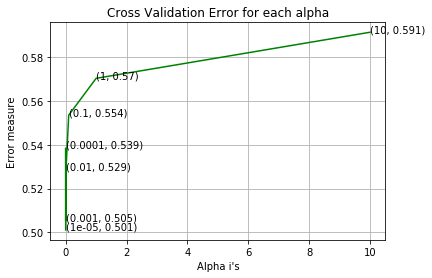

For values of best alpha =  1e-05 The train log loss is: 0.47979826071771675
For values of best alpha =  1e-05 The CV log loss is: 0.501113987723453
For values of best alpha =  1e-05 The test log loss is: 0.4970694856311993
Total number of data points : 15000


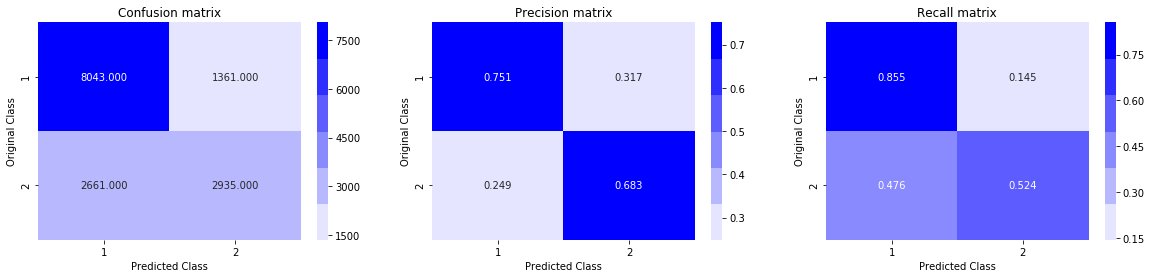

In [62]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(final_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(final_train, y_train)
    predict_y = sig_clf.predict_proba(final_val)
    log_error_array.append(log_loss(y_val, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_val, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(final_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(final_train, y_train)

predict_y = sig_clf.predict_proba(final_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(final_val)
print('For values of best alpha = ', alpha[best_alpha], "The CV log loss is:",log_loss(y_val, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(final_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

<h2> 4.5 Linear SVM with hyperparameter tuning </h2>

For values of alpha =  1e-05 The log loss is: 0.5000945078367823
For values of alpha =  0.0001 The log loss is: 0.5365556175457736
For values of alpha =  0.001 The log loss is: 0.5552343796397774
For values of alpha =  0.01 The log loss is: 0.547604907556973
For values of alpha =  0.1 The log loss is: 0.5738483159724186
For values of alpha =  1 The log loss is: 0.6302935757753225
For values of alpha =  10 The log loss is: 0.6364228833867522


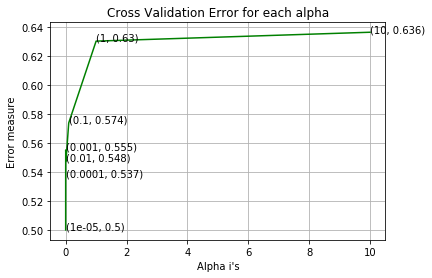

For values of best alpha =  1e-05 The train log loss is: 0.4817469011768157
For values of best alpha =  1e-05 The CV log loss is: 0.5000945078367823
For values of best alpha =  1e-05 The test log loss is: 0.4977953584826354
Total number of data points : 15000


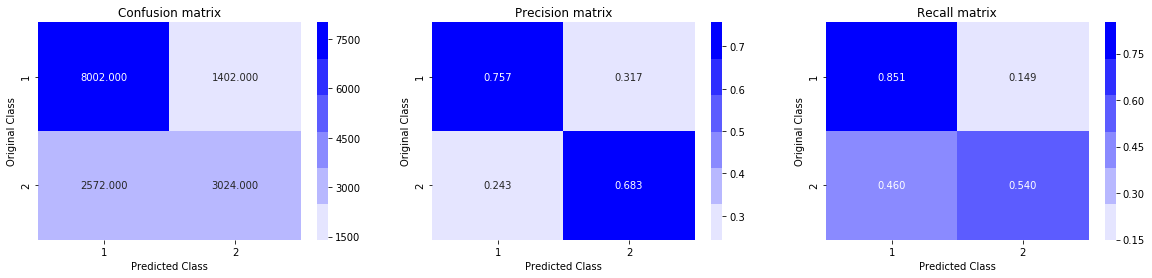

In [63]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(final_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(final_train, y_train)
    predict_y = sig_clf.predict_proba(final_val)
    log_error_array.append(log_loss(y_val, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_val, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(final_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(final_train, y_train)

predict_y = sig_clf.predict_proba(final_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(final_val)
print('For values of best alpha = ', alpha[best_alpha], "The CV log loss is:",log_loss(y_val, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(final_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

<h2> 4.6 XGBoost </h2>

In [64]:
print(final_train_tfidf_w2v.shape)
print(final_val_tfidf_w2v.shape)
print(final_test_tfidf_w2v.shape)

(24500, 218)
(10500, 218)
(15000, 218)


In [65]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

depth=[2, 5, 8, 10,15 ]
n_est=[5, 10,15,20, 25,30]
eta = [10 ** x for x in range(-5, 2)]

grid_parms={'max_depth':depth,'n_estimators':n_est,'eta':eta}
              
start_time = time.time()

#https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
xgb=XGBClassifier(booster='gbtree',scale_pos_weight=1,objective='binary:logistic',gamma = 0.1,eval_metric='logloss',seed=100)

gs=RandomizedSearchCV(xgb,grid_parms,verbose=True,n_jobs=-1)
gs_result=gs.fit(final_train_tfidf_w2v,y_train.values.reshape(-1,1))

# Summarize results
print("Best: %f using %s" % (gs_result.best_score_, gs_result.best_params_))
print("Execution time: " + str((time.time() - start_time)) + ' ms')

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.0min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.0min finished


Best: 0.776531 using {'n_estimators': 30, 'max_depth': 8, 'eta': 1e-05}
Execution time: 102.30196809768677 ms


## Conclusion
 -  Best hyperparameter using Randomizedsearchcv is {'n_estimators': 30, 'max_depth': 8, 'eta': 1e-05}

In [66]:
depth_srch = gs_result.best_params_['max_depth']
n_est_srch = gs_result.best_params_['n_estimators']
eta_srch = gs_result.best_params_['eta']

In [68]:
sol_train=pd.DataFrame(index=depth, columns=n_est)
for d in tqdm(depth):
    for e in n_est:
        gbdt = XGBClassifier(booster='gbtree',scale_pos_weight=1,objective='binary:logistic',
                                gamma = 0.1,eval_metric='auc',seed=100,max_depth=d,n_estimators=e,eta=eta_srch)
        gbdt.fit(final_train_tfidf_w2v, y_train.values.reshape(-1,1))
        y_prob_train = gbdt.predict_proba(final_train_tfidf_w2v.toarray())
        fpr_train, tpr_train, threshold_train = roc_curve(y_train, y_prob_train[:, 1])
        roc_auc_train = auc(fpr_train, tpr_train)
        sol_train.at[d,e] = roc_auc_train

#https://stackoverflow.com/questions/30485986/type-error-in-visualising-pandas-dataframe-as-heatmap
sol_train=sol_train[sol_train.columns].astype(float)

sol_val=pd.DataFrame(index=depth, columns=n_est)
for d in tqdm(depth):
    for e in n_est:
        gbdt_bow = XGBClassifier(booster='gbtree',scale_pos_weight=1,objective='binary:logistic',
                                gamma = 0.1,eval_metric='auc',seed=100,max_depth=d,n_estimators=e,eta=eta_srch)
        gbdt_bow.fit(final_train_tfidf_w2v, y_train.values.reshape(-1,1))
        y_prob_val = gbdt_bow.predict_proba(final_val_tfidf_w2v.toarray())
        fpr_val, tpr_val, threshold_val = roc_curve(y_val, y_prob_val[:, 1])
        roc_auc_val = auc(fpr_val, tpr_val)
        sol_val.at[d,e] = roc_auc_val
        
#https://stackoverflow.com/questions/30485986/type-error-in-visualising-pandas-dataframe-as-heatmap
sol_val=sol_val[sol_val.columns].astype(float)


100%|██████████| 5/5 [12:33<00:00, 164.68s/it]

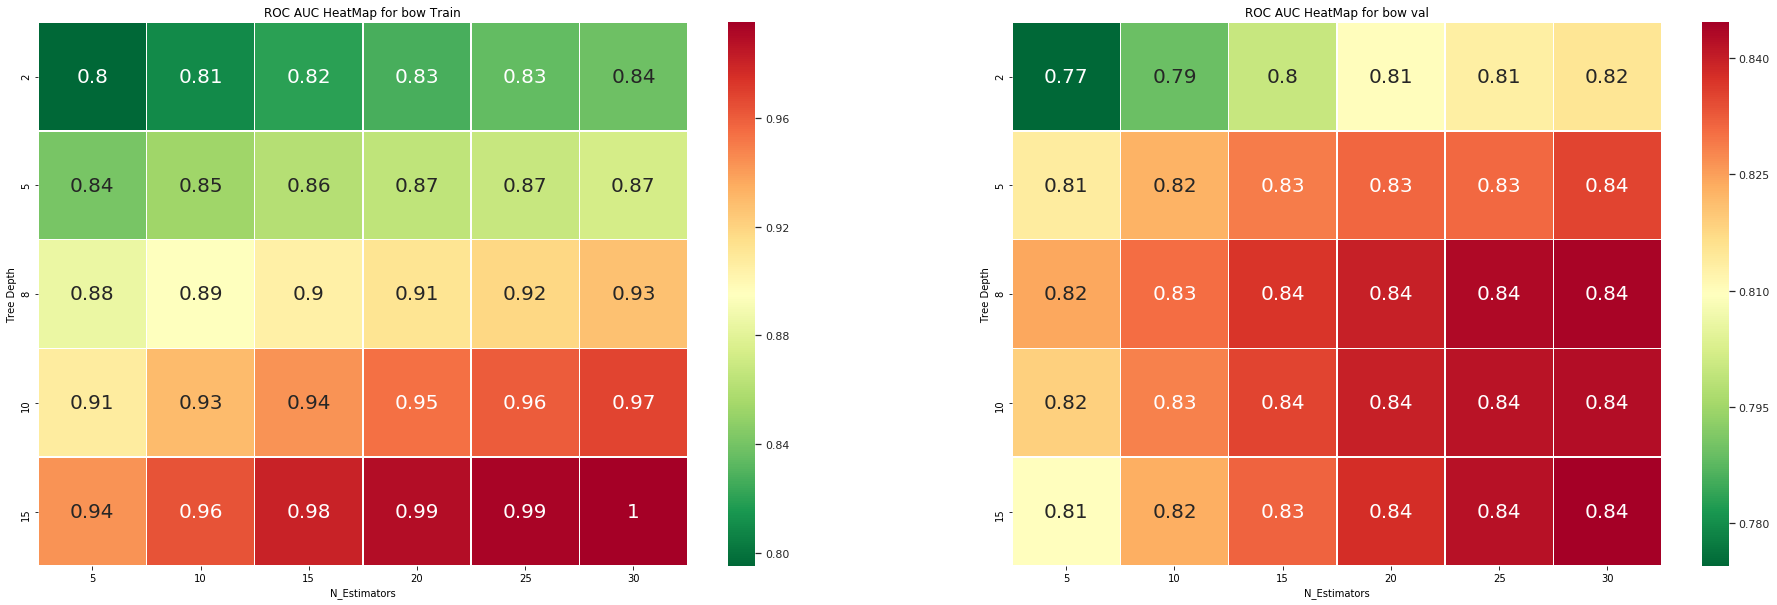

In [69]:
import seaborn as sn
fig, ax = plt.subplots(1, 2, figsize=(32,10))

sn.set(font_scale=1)#for label size
sn.heatmap(sol_train, ax=ax[0], cmap='RdYlGn_r',linewidths=0.5, annot_kws={"size": 20},annot=True)# font size
ax[0].set_xlabel('N_Estimators')
ax[0].set_ylabel('Tree Depth'); 
ax[0].set_title('ROC AUC HeatMap for bow Train'); 

sn.heatmap(sol_val, ax=ax[1], cmap='RdYlGn_r',linewidths=0.5, annot_kws={"size": 20}, annot=True)# font size
ax[1].set_xlabel('N_Estimators')
ax[1].set_ylabel('Tree Depth'); 
ax[1].set_title('ROC AUC HeatMap for bow val');

plt.show()

## Conclusion
 -  Best hyperparameter using manual method is {'n_estimators': 15, 'max_depth': 8, 'eta': 1e-05}

In [70]:
depth_srch = 8
n_est_srch = 15
eta_srch = gs_result.best_params_['eta']

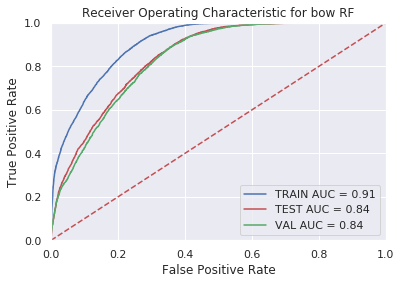

In [93]:
gbdt =XGBClassifier(booster='gbtree',scale_pos_weight=1.6805,objective='binary:logistic',
                                gamma = 0.1,eval_metric='auc',seed=100,
                            max_depth=depth_srch,n_estimators=n_est_srch,eta=eta_srch)
gbdt=gbdt.fit(final_train_tfidf_w2v,y_train)
y_prob_train = gbdt.predict_proba(final_train_tfidf_w2v.toarray())
y_prob_val = gbdt.predict_proba(final_val_tfidf_w2v.toarray())
y_prob_test = gbdt.predict_proba(final_test_tfidf_w2v.toarray())


fpr_train, tpr_train, threshold_train = roc_curve(y_train, y_prob_train[:, 1])
roc_auc_train = auc(fpr_train, tpr_train)
fpr_val, tpr_val, threshold_val = roc_curve(y_val, y_prob_val[:, 1])
roc_auc_val = auc(fpr_val, tpr_val)
fpr_test, tpr_test, threshold_test = roc_curve(y_test, y_prob_test[:, 1])
roc_auc_test_gbdt = auc(fpr_test, tpr_test)

plt.title('Receiver Operating Characteristic for bow RF')
plt.plot(fpr_train, tpr_train, 'b', label = 'TRAIN AUC = %0.2f' % roc_auc_train)
plt.plot(fpr_test, tpr_test, 'r', label = 'TEST AUC = %0.2f' % roc_auc_test_gbdt)
plt.plot(fpr_val, tpr_val, 'g', label = 'VAL AUC = %0.2f' % roc_auc_val)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [94]:
y_pred_train = gbdt.predict(final_train_tfidf_w2v)
y_pred_val = gbdt.predict(final_val_tfidf_w2v)
y_pred_test = gbdt.predict(final_test_tfidf_w2v)


#https://github.com/justmarkham/scikit-learn-videos/blob/master/09_classification_metrics.ipynb

confusion_matrix_test = confusion_matrix(y_test, y_pred_test)

TP_test = confusion_matrix_test[1, 1]
TN_test = confusion_matrix_test[0, 0]
FP_test = confusion_matrix_test[0, 1]
FN_test = confusion_matrix_test[1, 0]
TPR_test_gbdt= TP_test / (FN_test + TP_test)
TNR_test_gbdt= TN_test / (TN_test + FP_test)
FPR_test_gbdt= FP_test / (TN_test + FP_test)
FNR_test_gbdt = FN_test / (FN_test+TP_test)

confusion_matrix_train = confusion_matrix(y_train, y_pred_train)
TP_train = confusion_matrix_train[1, 1]
TN_train = confusion_matrix_train[0, 0]
FP_train = confusion_matrix_train[0, 1]
FN_train = confusion_matrix_train[1, 0]
TPR_train= TP_train / (FN_train + TP_train)
TNR_train= TN_train / (TN_train + FP_train)
FPR_train= FP_train / (TN_train + FP_train)
FNR_train = FN_train / (FN_train+TP_train)

confusion_matrix_val = confusion_matrix(y_val, y_pred_val)
TP_val = confusion_matrix_val[1, 1]
TN_val = confusion_matrix_val[0, 0]
FP_val = confusion_matrix_val[0, 1]
FN_val = confusion_matrix_val[1, 0]
TPR_val= TP_val / (FN_val + TP_val)
TNR_val= TN_val / (TN_val + FP_val)
FPR_val= FP_val / (TN_val + FP_val)
FNR_val = FN_val / (FN_val+TP_val)

from prettytable import PrettyTable
x = PrettyTable()

x.field_names = ["Data", "TPR","TNR","FPR","FNR"]
x.add_row(["Train",TPR_train,TNR_train,FPR_train,FNR_train])
x.add_row(["Test",TPR_test_gbdt,TNR_test_gbdt,FPR_test_gbdt,FNR_test_gbdt])
x.add_row(["Validation",TPR_val,TNR_val,FPR_val,FNR_val])

print(x)

+------------+--------------------+--------------------+---------------------+---------------------+
|    Data    |        TPR         |        TNR         |         FPR         |         FNR         |
+------------+--------------------+--------------------+---------------------+---------------------+
|   Train    | 0.961597374179431  |    0.701953125     |     0.298046875     | 0.03840262582056893 |
|    Test    | 0.8886704789135097 | 0.6634410888983411 | 0.33655891110165886 | 0.11132952108649034 |
| Validation | 0.8789890222108757 | 0.6651982378854625 | 0.33480176211453744 | 0.12101097778912433 |
+------------+--------------------+--------------------+---------------------+---------------------+


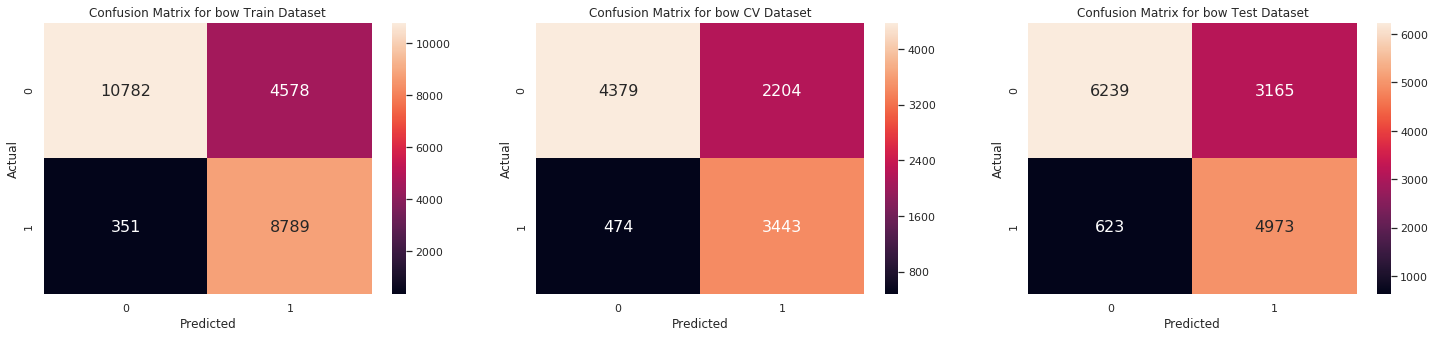

In [95]:
#https://www.kaggle.com/jesucristo/fraud-detection-eda-model-cv#Data
import seaborn as sn
fig, ax = plt.subplots(1, 3, figsize=(25,5))
sn.set(font_scale=1)#for label size

sn.heatmap(confusion_matrix_train,ax=ax[0], annot=True,annot_kws={"size": 16},fmt='g')# font size
ax[0].set_ylabel('Actual')
ax[0].set_xlabel('Predicted'); 
ax[0].set_title('Confusion Matrix for bow Train Dataset'); 
ax[0].xaxis.set_ticklabels(['0','1'])
ax[0].yaxis.set_ticklabels(['0','1']);

sn.heatmap(confusion_matrix_val,ax=ax[1], annot=True,annot_kws={"size": 16},fmt='g')# font size
ax[1].set_ylabel('Actual')
ax[1].set_xlabel('Predicted'); 
ax[1].set_title('Confusion Matrix for bow CV Dataset'); 
ax[1].xaxis.set_ticklabels(['0','1'])
ax[1].yaxis.set_ticklabels(['0','1']);

sn.heatmap(confusion_matrix_test,ax=ax[2], annot=True,annot_kws={"size": 16},fmt='g')# font size
ax[2].set_ylabel('Actual')
ax[2].set_xlabel('Predicted'); 
ax[2].set_title('Confusion Matrix for bow Test Dataset'); 
ax[2].xaxis.set_ticklabels(['0','1'])
ax[2].yaxis.set_ticklabels(['0','1']);

plt.show()

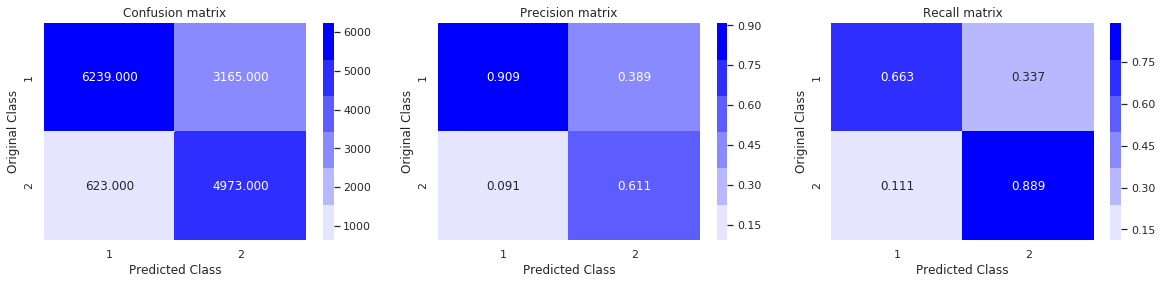

In [96]:
#predicted_y =np.array(predict_y>0.5,dtype=int)
#print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, y_pred_test)

<h1> 5. Assignments </h1>

1. Try out models (Logistic regression, Linear-SVM) with simple TF-IDF vectors instead of TD_IDF weighted word2Vec.
2. Hyperparameter tune XgBoost using RandomSearch to reduce the log-loss.
